# CNN Approach - US Equity Time Series Analysis
---

Now that the data is defined and cleaned, it is ready for analysis. Prior to using long short term memory approach to the time series analysis, I am going to develop a convolutional neural network (CNN) model.

## <a name="TOC"></a> Table of Contents:
---
1. [Load Data](#LOAD)
2. [Preprocessing](#PREPRO)
    1. [XY Split](#XY)
    2. [Train Test Split](#TRTS)
3. [CNN Architecture](#ARCH)
4. [CNN Training](#TRAIN)
5. [CNN Testing](#TEST)
6. [Conclusion](#CONC)


In [17]:
# ------------------------- SETUP ENVIRONMENT ------------------------- #

# Reset environment variables
%reset -f

# Standard math libraries
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.preprocessing import normalize

# Plotting
import matplotlib.pyplot as plt

# Import pathlib for directory control
from pathlib import Path

# Establish image save path
from pathlib import Path
path_images = Path('images')
path_data = Path('data')

# Importing tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

import pydot
import graphviz

# Silence warnings
import warnings
warnings.filterwarnings('ignore')

# Eagerly execute
tf.enable_eager_execution()
tf.executing_eagerly()


True

## <a name="LOAD"></a> [Load Data](#TOC)
---

Prior to analysis, we must load the data as a dataframe and ensure that it is working properly.

In [18]:
# ------------------------- SETUP ENVIRONMENT ------------------------- #

# Import the data from subdirectory
data = pd.read_csv(path_data / 'SP500.csv')

# Name date column
data.rename(columns = {'Unnamed: 0':'DATE'}, inplace = True)

# Swap last columns for X-Y
columnsTitles = ["DATE", "PE RATIO", "DIVIDEND YIELD", "EYTY RATIO", "ADJ PRICE"]
data = data.reindex(columns = columnsTitles)

# Look at first 5 instances of the data
data.head(5)


,DATE,PE RATIO,DIVIDEND YIELD,EYTY RATIO,ADJ PRICE
0,1999-06-01,28.66,1.23,0.580,1964.72
1,1999-07-01,28.66,1.23,0.580,1964.72
2,1999-08-01,28.66,1.23,0.580,1964.72
3,1999-09-01,28.66,1.23,0.580,1964.72
4,1999-10-01,28.66,1.23,0.582,1964.72


## <a name="PREPRO"></a> [Preprocessing](#TOC)
---

Here we must eleminate the dataframe by pulling the features as individual arrays and reappending them into an hstacked array before running an X-Y split on them which will act as our custom API for training. Prior to this split we can normalize the data columns. We will use a function of our own design for the split. After this stage, we will split the sequence into a training and a testing data base. Keep in mind that the order of the data matters, so we will not randomly select discrete data points but will select 65 % to 70 % of the data's timeframe for training and the remaining 35 % to 30% for testing.

In [19]:
# ------------------------- DATA TREATMENT ------------------------- #

# Isolate data features
in1 = data["PE RATIO"].values
in2 = data["DIVIDEND YIELD"].values
in3 = data["EYTY RATIO"].values

# Isolate data label
out = data["ADJ PRICE"].values

# Convert to [rows, columns] structure
in1 = in1.reshape((len(in1), 1))
in2 = in2.reshape((len(in2), 1))
in3 = in3.reshape((len(in3), 1))
out = out.reshape((len(out), 1))

# Preallocate
out_ret = []

# Convert price to price change
for i in range(len(out)):
    
    if (i == 0):
        out_ret.append(0)
    else:
        out_ret.append( round(float(((out[i] / out[i-1]) - 1)), 8) )
    
# Swap out with out return
out_ret = np.asarray(out_ret).reshape((len(out_ret), 1))

# Normalize feature columns
in1_norm = normalize(in1, norm = 'max', axis = 0)
in2_norm = normalize(in2, norm = 'max', axis = 0)
in3_norm = normalize(in3, norm = 'max', axis = 0)

# ------------------------- FEATURE-LABEL ASSOCIATION ------------------------- #

# Check if the shape of the columns is secure
if ( len(in1) == len(in2) & len(in2) == len(in3) & len(in3) == len(out_ret) ):
    
    # Horizontally stack columns
    dataseries = np.hstack((in1_norm, in2_norm, in3_norm, out_ret))
    
# Print error if there is missing of mismatched data
else: print("ERROR: Column lengths mismatch.")

# Turn off scientific notation
np.set_printoptions(suppress = True)

# Print sample of matrix
dataseries[0:15]


array([[ 0.2316334 ,  0.34166667,  0.12840381,  0.        ],
       [ 0.2316334 ,  0.34166667,  0.12840381,  0.        ],
       [ 0.2316334 ,  0.34166667,  0.12840381,  0.        ],
       [ 0.2316334 ,  0.34166667,  0.12840381,  0.        ],
       [ 0.2316334 ,  0.34166667,  0.12884658,  0.        ],
       [ 0.24036208,  0.34444444,  0.12264778,  0.06935339],
       [ 0.23971551,  0.33333333,  0.12021253,  0.02708736],
       [ 0.24003879,  0.33888889,  0.12176223, -0.01318418],
       [ 0.22435949,  0.35      ,  0.12043392, -0.02357897],
       [ 0.22880466,  0.35555556,  0.122205  ,  0.02991492],
       [ 0.22662248,  0.35277778,  0.12176223, -0.01452301],
       [ 0.22217732,  0.325     ,  0.12818242, -0.00370558],
       [ 0.22759234,  0.325     ,  0.12685411,  0.0252698 ],
       [ 0.22484442,  0.325     ,  0.12840381, -0.01232581],
       [ 0.22605674,  0.31944444,  0.13216737,  0.02637771]])

### <a name="XY"></a> [XY Split](#TOC)
---

Here we will split the features and label from each other so that we can send the data into the CNN efficiently.

In [20]:
# ------------------------- DEFINE SPLIT FUNCTION ------------------------- #

# Split a multivariate sequence into samples
def split_sequences(sequences, n_steps, debug):

    # Preallocate 
    X, y = list(), list()

    # For each element in the sequence
    for i in range(len(sequences)):

        # Find the end of this pattern
        end_ix = i + n_steps

        # Avoid collision with the end of set
        if end_ix > len(sequences):
            break

        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]

        # Print for debugging
        if debug:
            print("{}: \tX:{} \ty:{}\n".format(i, seq_x, seq_y))

        # Append sequences to split arrays
        X.append(seq_x)
        y.append(seq_y)
    
    # Return
    return np.array(X), np.array(y)


In [21]:
# ------------------------- FEATURE-LABEL DISASSOCIATION ------------------------- #

# Choose a number of time steps
n_steps = 1
n_features = np.shape(dataseries)[1] - 1

# Feature/label split
X, y = split_sequences(dataseries, n_steps, False)
print("Shape X: {}. Shape y: {}\n".format(X.shape, y.shape))

# Summarize 10% of the the data
print("Data Summary:")
for i in range( np.floor(len(X)/10).astype(int) ):
    print("\t", X[i], y[i])


Shape X: (239, 1, 3). Shape y: (239,)

Data Summary:
	 [[0.2316334  0.34166667 0.12840381]] 0.0
	 [[0.2316334  0.34166667 0.12840381]] 0.0
	 [[0.2316334  0.34166667 0.12840381]] 0.0
	 [[0.2316334  0.34166667 0.12840381]] 0.0
	 [[0.2316334  0.34166667 0.12884658]] 0.0
	 [[0.24036208 0.34444444 0.12264778]] 0.06935339
	 [[0.23971551 0.33333333 0.12021253]] 0.02708736
	 [[0.24003879 0.33888889 0.12176223]] -0.01318418
	 [[0.22435949 0.35       0.12043392]] -0.02357897
	 [[0.22880466 0.35555556 0.122205  ]] 0.02991492
	 [[0.22662248 0.35277778 0.12176223]] -0.01452301
	 [[0.22217732 0.325      0.12818242]] -0.00370558
	 [[0.22759234 0.325      0.12685411]] 0.0252698
	 [[0.22484442 0.325      0.12840381]] -0.01232581
	 [[0.22605674 0.31944444 0.13216737]] 0.02637771
	 [[0.220965   0.32777778 0.1425725 ]] -0.01684491
	 [[0.22355128 0.32222222 0.13725924]] 0.00856443
	 [[0.21740887 0.31388889 0.14345805]] -0.07141802
	 [[0.21514588 0.30833333 0.15076378]] -0.03363203
	 [[0.21627738 0.31111111

### <a name="TRTS"></a> [Train Test Split](#TOC)
---

Normally with ANN training data, we would randomly select points from the dataset for prediction purposes. In the case of time series analysis, we cannot approach the train test split by treating the data as a set, we must preserve the relationship between one point and the next point as a successive series of complex relationships. Consequently, our split will randomly select a point about the 65 % to 75 % line and divide the time series below this line as the training data and the time series after the line of demarcation as the test data. This way we can accurately gauge the algorithms ability to predict time series.

In [22]:
# ------------------------- TRAIN TEST SPLIT ------------------------- #

# Select random line of demarcation
demarc = np.random.uniform(low = 0.65, high = 0.75, size = 1)

# Find split range
split = (np.ceil( len(X) * demarc ))[0].astype(int)

# Split training data
X_train = X[ 0 : split ]
y_train = y[ 0 : split ]

# Split test data
X_test = X[ split : len(X) ]
y_test = y[ split : len(X) ]

# Ensure that data is not lost
if ( len(X_train) + len(X_test) != len(X) ):
    print("ERROR: Train test split did not include all of the dataseries.")


<Figure size 432x288 with 0 Axes>

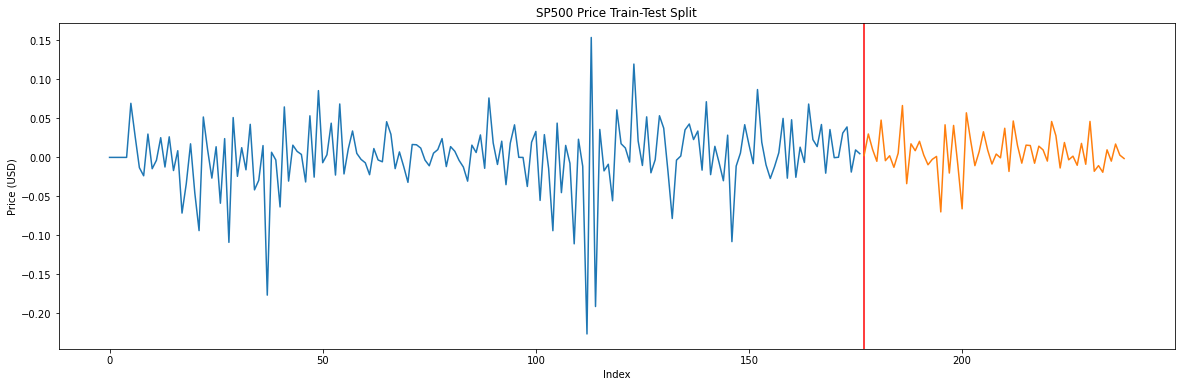

In [23]:
# ------------------------- PLOT SPLIT FOR CONFIRMATION ------------------------- #

# Plot train test split
fig1 = plt.figure()
plt.figure(figsize = (20, 6))
plt.plot(y_train)
plt.axvline(x = len(y_train), color = 'red')
plt.plot([None for i in y_train] + [x for x in y_test])
plt.title('SP500 Price Train-Test Split')
plt.xlabel('Index')
plt.ylabel('Price (USD)')
plt.savefig(path_images / 'cnn_train-test-split.png', bbox_inches = 'tight')
plt.show()


Looks good, this will preserve the sequential nature of the relationship.

## <a name="ARCH"></a> [CNN Architecture](#TOC)
---

With the data split it is time to begin designing the architecture of the CNN. We will instantiate the network prior to training, which will occur in the next section.

In [24]:
# ------------------------- CNN DESIGN ------------------------- #

# Create model
model = keras.models.Sequential()
model.add( keras.layers.Conv1D(filters = 64, kernel_size = 1, activation = 'relu', input_shape = np.shape(X_train)[1:3]) )
model.add( keras.layers.MaxPooling1D(pool_size = 1) )
model.add( keras.layers.Flatten() )
model.add( keras.layers.Dense(50, activation = 'relu') )
model.add( keras.layers.Dense(1) )
model.compile( optimizer = 'adam', loss = 'mse' )

# Save figure of model design
plot_model(model, to_file = path_images / 'cnn_model.png')


## <a name="TRAIN"></a> [CNN Training](#TOC)
---

With our model design complete, we can fit the data to the model and proceed with our analysis.

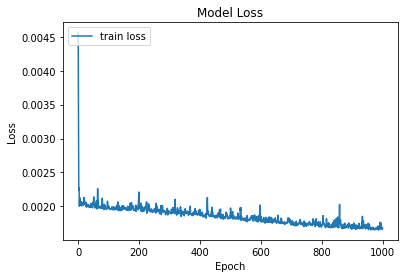

In [25]:
# ------------------------- CNN TRAINING ------------------------- #

# Fit model
history = model.fit(X_train, y_train, epochs = 1000, verbose = 0)

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train loss'], loc='upper left')
plt.savefig(path_images / 'cnn_training-loss.png', bbox_inches='tight')
plt.show()


## <a name="TEST"></a> [CNN Testing](#TOC)
---

Now we can use the test data to find if the model is ultimately predictive.

<Figure size 432x288 with 0 Axes>

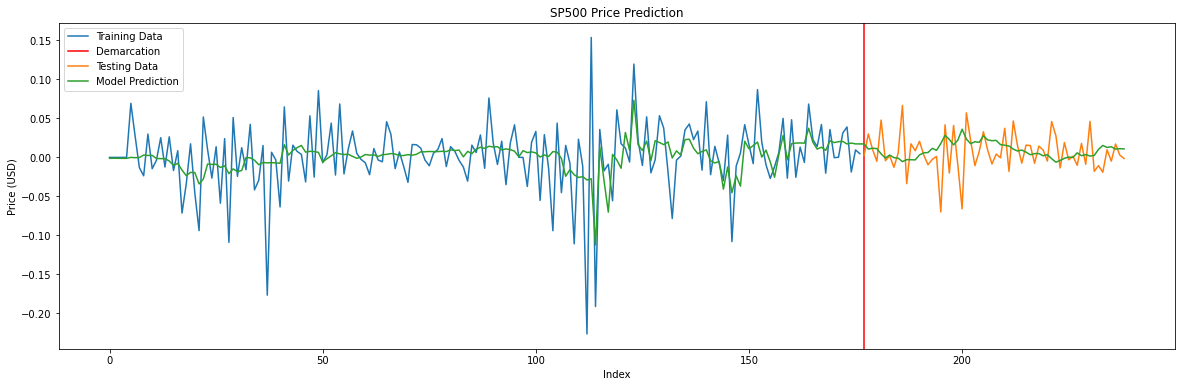

In [26]:
# ------------------------- CNN TESTING ------------------------- #

# Form predictions for SP500
y_pred = model.predict(X, verbose = 0)

# Plot train test split with predictions
fig1 = plt.figure()
plt.figure( figsize = (20, 6) )
line1 = plt.plot( y_train )
plt.axvline( x = len(y_train), color = 'red' )
line2 = plt.plot( [None for i in y_train] + [x for x in y_test] )
line3 = plt.plot( y_pred )
plt.legend( ('Training Data', 'Demarcation', 'Testing Data', 'Model Prediction'), loc = 'upper left' )
plt.title('SP500 Price Prediction')
plt.xlabel('Index')
plt.ylabel('Price (USD)')
plt.savefig(path_images / 'cnn_return-predictions.png', bbox_inches='tight')
plt.show()


In [27]:
# ------------------------- GET PRICES FROM RETURN ------------------------- #

# Preallocate for the process 
start = out[0]
close_test = []
close_pred = []

# Create dataframe for ease of computing
df = pd.DataFrame(data = out_ret, columns = ['Real Return'])

# Append real close
df['Real Price'] = start * (1 + df['Real Return']).cumprod()

# Append predicted return
df['Pred Return'] = pd.Series(y_pred.reshape(len(y_pred),), index = df.index)

# Append predicted close
df['Pred Price'] = start * (1 + df['Pred Return']).cumprod()

# Inspect the data
df.head(10)


,Real Return,Real Price,Pred Return,Pred Price
0,0.000000,1964.720000,-0.001082,1962.593347
1,0.000000,1964.720000,-0.001082,1960.469036
2,0.000000,1964.720000,-0.001082,1958.346951
3,0.000000,1964.720000,-0.001082,1956.227207
4,0.000000,1964.720000,-0.001215,1953.851117
5,0.069353,2100.979992,0.000010,1953.871143
6,0.027087,2157.889994,-0.000378,1953.132318
7,-0.013184,2129.439984,-0.000194,1952.753830
8,-0.023579,2079.229982,0.003007,1958.625195
9,0.029915,2141.429981,0.002474,1963.470943


<Figure size 432x288 with 0 Axes>

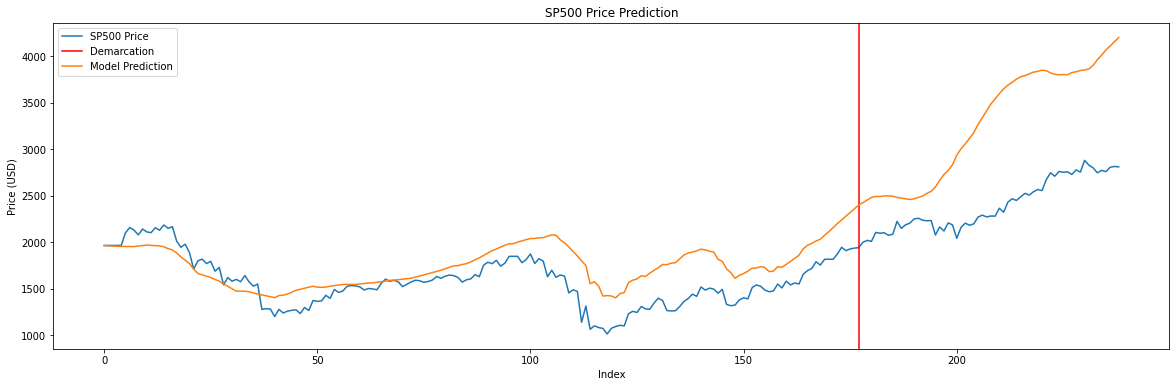

In [28]:
# Plot train test split with predictions
fig1 = plt.figure()
plt.figure( figsize = (20, 6) )
plt.plot( data["ADJ PRICE"] )
plt.axvline( x = len(y_train), color = 'red' )
plt.plot( df['Pred Price'] )
plt.legend( ('SP500 Price', 'Demarcation', 'Model Prediction'), loc = 'upper left' )
plt.title('SP500 Price Prediction')
plt.xlabel('Index')
plt.ylabel('Price (USD)')
plt.savefig(path_images / 'cnn_price-predictions.png', bbox_inches='tight')
plt.show()


In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = np.sqrt(((df['Pred Price'] - data["ADJ PRICE"]) ** 2).mean())
rms

535.42030509885

## <a name="CONC"></a> [Conclusion](#TOC)
---

This model is more indicative of what is going on here, the CNN can predict general trends but the pricing accuracy is awful. It appears that smaller price changes have not be detected by the model whereas larger trends have been noted, this is consistent with the behavior of neural networks as a whole. All in all, not a horrible model.